# Step-wise Feature selection (Network only)
Forward step-wise selection of the best features to use, following a greedy approach.

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from matplotlib import colors
import copy

In [2]:
path = "../features/normalized/"
names = ["betweenness", "community_count", "community_size", "ks_level_1", "ks_level_2"]
np.random.seed(42)
samples_per_class = 35
model = LogisticRegression(random_state=42)

In [3]:
# Load features from .npz files
original_labels = np.load(path + names[0] + "_norm.npz")['y']
original_features = np.load(path + names[0] + "_norm.npz")['X']
columns = [original_features.shape[1]]
for filename in names[1:]:
    file_path = path + filename + "_norm.npz"
    data = np.load(file_path)
    feature_matrix = data['X']
    columns.append(feature_matrix.shape[1])
    original_features = np.concatenate((original_features, feature_matrix), axis=1)

# Over-sample
original_samples_per_class = {label: np.sum(original_labels == label) for label in np.unique(original_labels)}
sampling_strategy = {label: max(samples_per_class, original_samples) for label, original_samples in original_samples_per_class.items()}
ros = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy)
oversampled_features, oversampled_labels = ros.fit_resample(original_features, original_labels)
# Under-sample
updated_samples_per_class = {label: np.sum(oversampled_labels == label) for label in np.unique(original_labels)}
sampling_strategy = {label: min(samples_per_class, original_samples) for label, original_samples in updated_samples_per_class.items()}
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
undersampled_features, labels = rus.fit_resample(oversampled_features, oversampled_labels)

# Build features list
features = []
current = 0
for c in columns:
    feature = undersampled_features[:, current:current + c]
    features.append(feature)
    current += c

In [4]:
# Perform feature selection and record accuracies
num_features = len(features)
remaining_features = list(range(num_features))
already_used_features = []
accuracies = []

null_model_accuracy = 0

# Feature selection iterations
it = 0
accuracy_matrix = np.zeros((num_features, num_features))
while remaining_features:
    best_accuracy = 0
    best_feature = None

    for feature_index in remaining_features:
        current_features = already_used_features + [feature_index]
        X = np.hstack([features[i] for i in current_features])

        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
        # Perform logistic regression and compute accuracy
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        accuracy_matrix[it][feature_index] = accuracy
        print(f"Model with features {current_features}: accuracy = {accuracy*100:4.2f}.")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature_index

    # Update lists
    accuracies.append(best_accuracy)
    remaining_features.remove(best_feature)
    already_used_features.append(best_feature)
    it += 1

Model [0][0]: accuracy = 29.98.
Model [0][1]: accuracy = 1.51.
Model [0][2]: accuracy = 88.62.
Model [0][3]: accuracy = 57.26.
Model [0][4]: accuracy = 87.93.
Model [1][0]: accuracy = 88.52.
Model [1][1]: accuracy = 88.64.
Model [1][3]: accuracy = 88.43.
Model [1][4]: accuracy = 89.19.
Model [2][0]: accuracy = 89.13.
Model [2][1]: accuracy = 89.21.
Model [2][3]: accuracy = 89.13.
Model [3][0]: accuracy = 89.21.
Model [3][3]: accuracy = 89.13.
Model [4][3]: accuracy = 89.06.


In [5]:
already_used_features

[2, 4, 1, 0, 3]

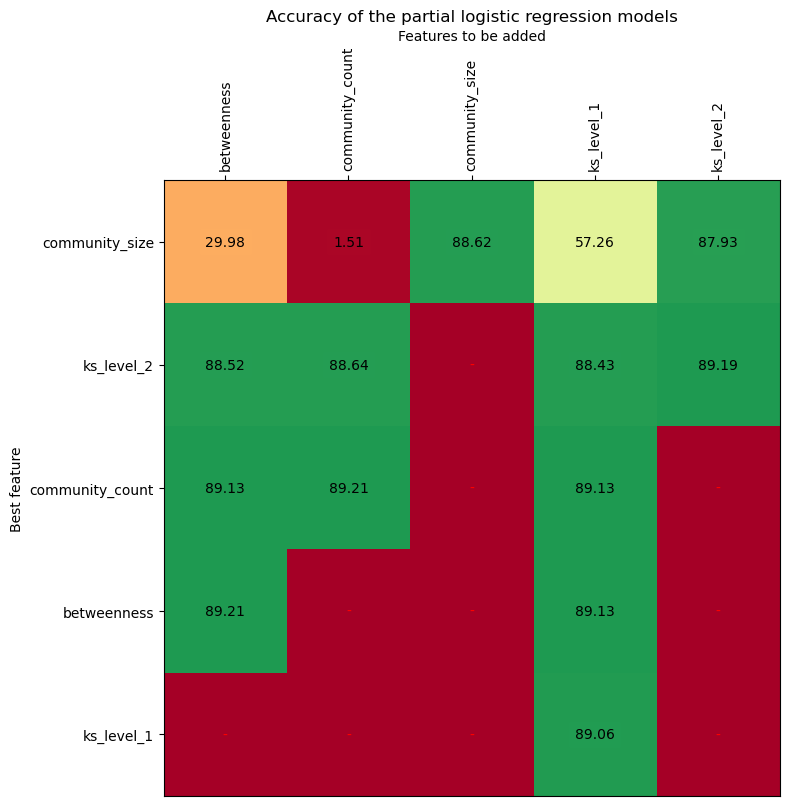

In [6]:
# Plot model accuracies with custom colormap
norm = colors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('RdYlGn')
plt.figure(figsize=(8, 8))
plt.imshow(accuracy_matrix, cmap=cmap, norm=norm)
tick_marks = np.arange(num_features)
reordered_names = [names[i] for i in already_used_features]
plt.xticks(tick_marks, labels=names, rotation='vertical', ha='center')  # Set custom tick marks
plt.yticks(tick_marks, labels=reordered_names)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Features to be added")
plt.ylabel("Best feature")

# Add text with colored background based on the value
for i in range(num_features):
    for j in range(num_features):
        val = accuracy_matrix[i, j]
        color = cmap(norm(val))
        plt.text(j, i, f"{val*100:4.2f}" if val != 0 else '-', ha='center', va='center', color='red' if val == 0 else 'black', backgroundcolor=color)

plt.title(f"Accuracy of the partial logistic regression models")
plt.show()

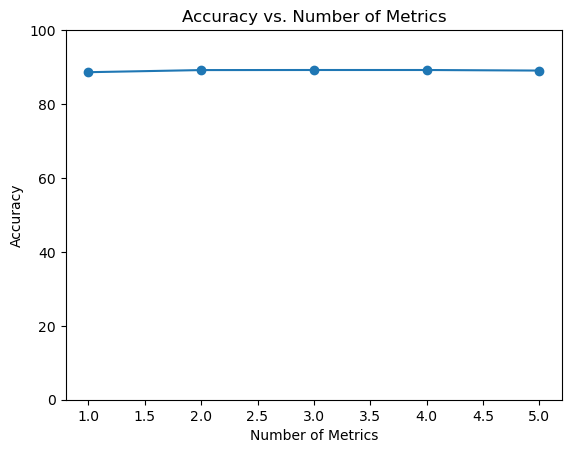

In [7]:
# Plot accuracies for each best model
plt.plot(np.arange(1, len(accuracies)+1), np.array(accuracies)*100, marker='o')
plt.xlabel('Number of Metrics')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.title('Accuracy vs. Number of Metrics')
plt.show()

In [8]:
accuracies

[0.8861726508785333,
 0.8919022154316272,
 0.8920932009167303,
 0.8920932009167303,
 0.8905653170359052]